## L-mode H-mode  Classifier

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import confinement_mode_classifier as cmc
from datetime import datetime
import time 
import re
import random
import torchvision
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

Seed set to 42


Device: cuda:0


In [2]:
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:

data_dir_path = '/compass/Shared/Users/bogdanov/vyzkumny_ukol/data/LHmode-detection-shots'
file_names = os.listdir(data_dir_path)


In [4]:
batch_size = 32
shot_numbers = [re.search(r'shot(\d+)', file_name).group(1) for file_name in file_names]
removed_shots = ['13182', '20009']
shot_numbers = [valid_shot for valid_shot in shot_numbers if valid_shot not in removed_shots]

shots_for_testing = ['18130', '16773', '16534', '19094', '18133']
shots_for_validation = ['16769', '19379', '18057', '18132']
shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True)


test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size)
val_dataloader = cmc.get_dloader(val_df, path=path, batch_size=batch_size)
train_dataloader = cmc.get_dloader(train_df, path=path, batch_size=batch_size)

### Create dataloader, that will be used in training

In [5]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [7]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S ") + input('add comment: ')

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}_last_fc')

## Import ResNet pretrained model
### And freeze all layers except last f.c. layer


In [8]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

### Hyperparameters

In [9]:
#
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train last fc of the model

In [11]:
# from tqdm.notebook import tqdm

# for batch in tqdm(dataloaders['train']):
#     inspector = batch

In [23]:
timestamp

'14-01-2024, 15-12-00 Train on new data, elms on_last_fc'

In [12]:


num_epochs = 2
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                       dataloaders, writer, dataset_sizes, num_epochs=num_epochs)
model_path = Path(f'{path}/runs/{timestamp}/model_fc_trained.pt')
torch.save(model.state_dict(), model_path)

Epoch 1/2
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.6117 Acc: 0.7502


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 0.7559 Acc: 0.6701
Epoch 2/2
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.4306 Acc: 0.8210


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 0.7909 Acc: 0.6871
Training complete in 19m 56s
Best val Acc: 0.687120


RuntimeError: Parent directory /compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/14-01-2024, 15-12-00 Train on new data, elms on_last_fc does not exist.

### Test model with last fc trained

Processing batches:   0%|          | 0/326 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_582142/3679196964.py", line 1, in <module>
    predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy, pr_curve, roc_curve = cmc.test_model(f'runs/{timestamp}',
  File "/compass/Shared/Users/bogdanov/vyzkumny_ukol/confinement_mode_classifier.py", line 520, in test_model
  File "/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/PIL/Image.py", line 2435, in save
    fp = builtins.open(filename, "w+b")
FileNotFoundError: [Errno 2] No such file or directory: 'runs/14-01-2024, 15-12-00 Train on new data, elms on/metrics_for_whole_test_dset_last_fc.png'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-pack

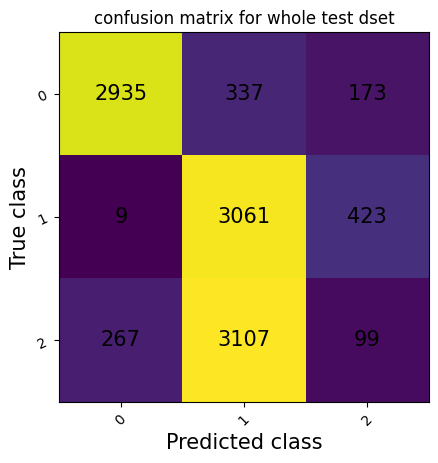

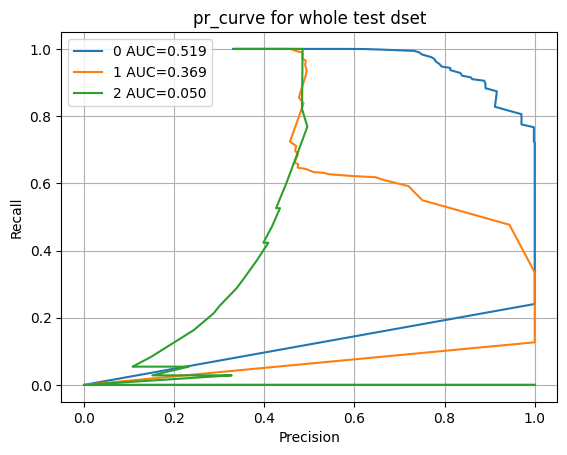

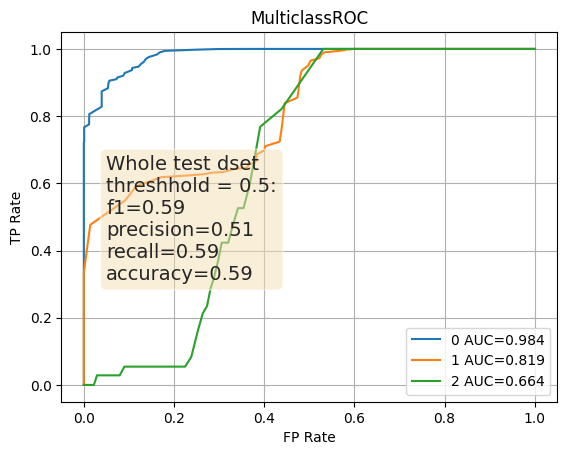

In [27]:

predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy, pr_curve, roc_curve = cmc.test_model(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/14-01-2024, 15-12-00 Train on new data, elms on_last_fc', 
                                                                                                            model, test_dataloader,
                                                                                                            comment='last_fc'
                                                                                                            )
# writer.add_figure(f'Confusion matrix for the model with trained f.c. layer', fig_confusion_matrix)
# writer.add_scalar(f'Accuracy on test_dataset with trained f.c. layer', accuracy)
# writer.add_scalar(f'F1 metric on test_dataset with trained f.c. layer', f1)
# writer.add_scalar(f'Precision on test_dataset with trained f.c. layer', precision)
# writer.add_scalar(f'Recall on test_dataset with trained f.c. layer', recall)
# writer.close()

In [ ]:
predictions_df

,shot,prediction,label,time,confidence,L_logit,H_logit,ELM_logit
0,16534,1,1,1169.2,0.954523,-3.131240,2.484850,-0.638594
1,18130,1,1,1149.8,0.408055,-0.505234,0.038124,-0.101303
2,19094,0,0,1310.4,0.993954,3.604779,-1.662138,-3.382417
3,16773,0,0,1321.0,0.979947,2.679731,-1.344853,-3.275626
4,16534,1,1,1163.2,0.986639,-3.520378,3.255379,-1.134616
...,...,...,...,...,...,...,...,...
10406,18133,2,1,1159.2,0.564901,-0.617354,-0.426327,0.436938
10407,16534,1,1,1202.2,0.989592,-3.311272,3.244900,-1.454965
10408,16534,1,2,1149.8,0.923631,-3.090610,2.162799,-0.395272
10409,16534,1,2,1149.8,0.923631,-3.090610,2.162799,-0.395272


In [ ]:
f1

tensor(0.5713)

In [ ]:
precision

tensor(0.5139)

In [ ]:
recall

tensor(0.5715)

In [ ]:
accuracy

0.5713187974257996

## Train the whole model

In [28]:
writer = SummaryWriter(f'runs/{timestamp}_all_layers')
for param in model.parameters():
    param.requires_grad = True
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders, writer, dataset_sizes, num_epochs=6)
model_path = Path(f'{path}/runs/{timestamp}_all_layers/model_fully_trained.pt')
torch.save(model.state_dict(), model_path)

Epoch 1/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.2624 Acc: 0.8972


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 5.4393 Acc: 0.3981
Epoch 2/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.1828 Acc: 0.9298


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 1.4422 Acc: 0.7158
Epoch 3/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.1490 Acc: 0.9418


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 1.5629 Acc: 0.6853
Epoch 4/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.1277 Acc: 0.9531


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 3.9110 Acc: 0.5637
Epoch 5/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.0981 Acc: 0.9648


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 2.3276 Acc: 0.6797
Epoch 6/6
----------


  0%|          | 0/502 [00:00<?, ?it/s]

train Loss: 0.0379 Acc: 0.9891


  0%|          | 0/258 [00:00<?, ?it/s]

val Loss: 3.1085 Acc: 0.6971
Training complete in 73m 39s
Best val Acc: 0.715796


### Test model with all layers trained

In [ ]:
from importlib import reload
reload(cmc)
predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy, pr_curve, roc_curve = cmc.test_model(f'runs/{timestamp}', 
                                                                                                            model, test_dataloader,
                                                                                                            comment='all_layers'
                                                                                                            )
# writer.add_figure(f'Confusion matrix for the model with trained f.c. layer', fig_confusion_matrix)
# writer.add_scalar(f'Accuracy on test_dataset with trained f.c. layer', accuracy)
# writer.add_scalar(f'F1 metric on test_dataset with trained f.c. layer', f1)
# writer.add_scalar(f'Precision on test_dataset with trained f.c. layer', precision)
# writer.add_scalar(f'Recall on test_dataset with trained f.c. layer', recall)
# writer.close()

Seed set to 42


Device: cuda:0


Processing batches:   0%|          | 0/197 [00:00<?, ?it/s]